<a href="https://www.kaggle.com/code/hwanchul/lending-club-prep?scriptVersionId=262554678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 데이터 불러오기

In [1]:
import kagglehub
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df1 = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv', low_memory=False)
#df2 = pd.read_csv('/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv', low_memory=False)

print("--- df1's info ---")
df1.info()

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv
--- df1's info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## 프로젝트 목표 
___
- 대출자의 부도 예측: 대출 상환에 실패할 (Default) 대출자를 사전에 예측하는 분류(Classification) 문제.

- 타겟 변수 정의
    - loan_status를 활용하여 label 변수 생성
    
        - 부도(Default) 그룹: Charged Off, Default, Late (31-120 days)
    
        - 정상(Non-Default) 그룹: Fully Paid, Current
    
        - In Grace Period는 아직 부도로 확정되지 않은 상태이므로, 분석 목적에 따라 정상 그룹에 포함하거나 제외할 수 있습니다.

# 분석데이터 만들기

## 데이터 필터링
___

In [2]:
# 대출승인날짜(issue_d)를 토대로 대출승인 년도(issue_year), 월(issue_month), 분기(issue_quarter) 정보 추출

df1.dropna(subset=['issue_d'], inplace=True) ## issue_d 결측 데이터 삭제 --> 33개

df1['issue_month'] = df1['issue_d'].str.split('-', expand=True)[0]
df1['issue_year'] = df1['issue_d'].str.split('-', expand=True)[1].astype(int)

def get_quarter(month):
    if month in ['Jan', 'Feb', 'Mar']:
        return 'Q1'
    elif month in ['Apr', 'May', 'Jun']:
        return 'Q2'
    elif month in ['Jul', 'Aug', 'Sep']:
        return 'Q3'
    else:
        return 'Q4'

df1['issue_quarter'] = df1['issue_month'].apply(get_quarter)

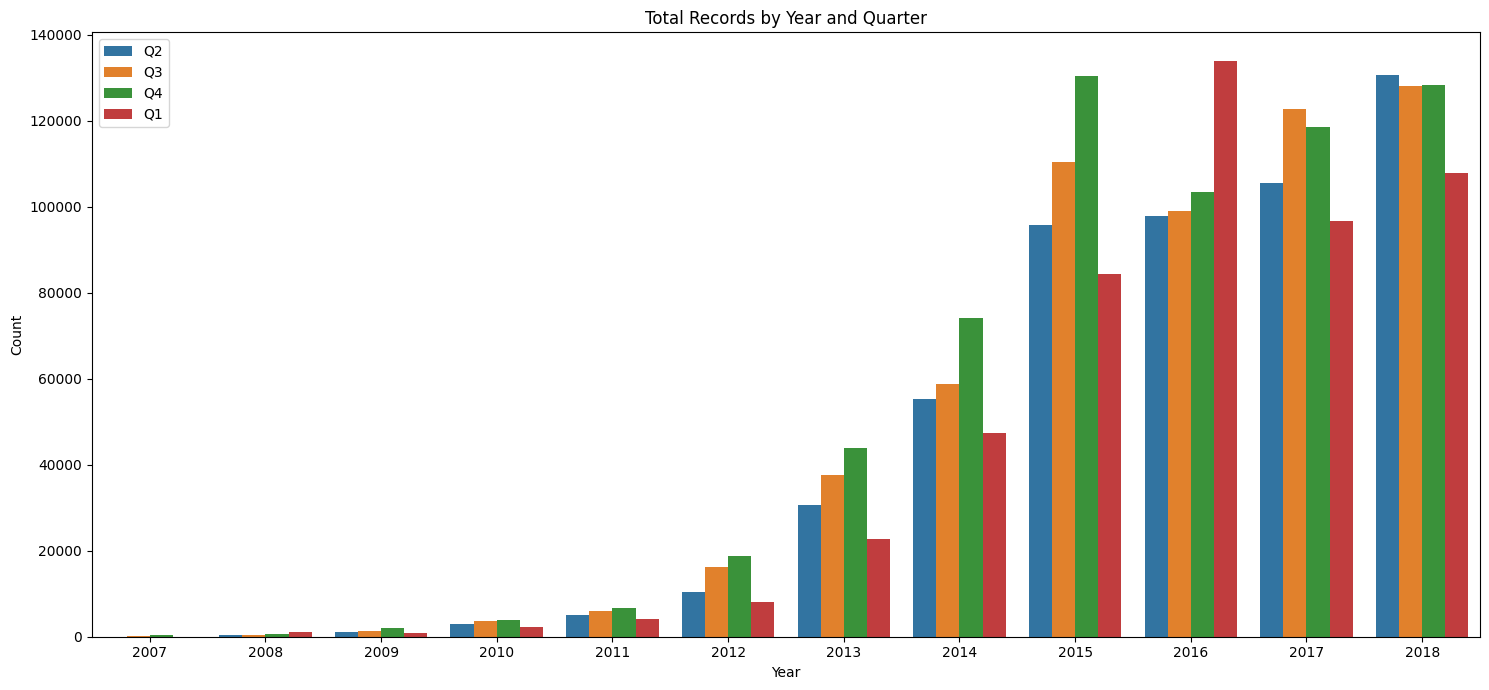

In [3]:
# 연도별 총 레코드 수 계산
total_records_by_year = df1['issue_year'].value_counts().sort_index()

# 연도-분기별 총 레코드 수
total_records_by_quater = df1.groupby(['issue_year', 'issue_quarter'])['issue_d'].count().sort_index()
total_records_by_quater.name = 'count'

# 연도-분기별 총 레코드 수 시각화
plt.figure(figsize=(15, 7))

sns.barplot(x='issue_year', y='count', hue='issue_quarter', data=total_records_by_quater.reset_index())
plt.title('Total Records by Year and Quarter')
plt.xlabel('Year'); plt.ylabel('Count')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 타겟 변수 정의
___


`loan_status`를 활용하여 `is_default` 변수 생성

- 부도(Default) 그룹: Charged Off, Default, Late (31-120 days)

- 정상(Non-Default) 그룹: Fully Paid, Current

- In Grace Period는 아직 부도로 확정되지 않은 상태이므로, 분석에서 제외하였음


대출 상태(loan_status) 값별 의미
___
NonDefault Group
- Fully Paid: 대출자가 모든 원금과 이자를 전액 상환하여 대출 계약이 완료된 상태입니다. 이는 대출 상환에 성공한 사례로 분류됩니다.

- Current: 대출자가 현재 상환 기한을 잘 지키고 있는 상태입니다. 이 대출들은 아직 계약이 끝나지 않았으며, 현재로서는 부도 위험이 없는 것으로 간주됩니다.

Default Group
- Charged Off: 대출 상환이 불가능하다고 판단되어 부도 처리된 상태입니다. 이는 회수 가능성이 낮아 손실로 기록된 경우입니다. 모델링에서는 주로 이 값을 '부도(Default)'로 정의합니다.

- Late (31-120 days): 대출 상환일로부터 31일에서 120일 사이로 연체된 상태입니다.

- Late (16-30 days): 상환일로부터 16일에서 30일 사이로 연체된 상태입니다.

- Default: 대출 상환 의무를 이행하지 못해 부도 상태에 빠진 경우입니다. Charged Off와 유사하지만, Lending Club의 내부 정책에 따라 부도 처리 전 단계로 분류될 수 있습니다.

Else
- In Grace Period: 상환일로부터 15일의 유예 기간 내에 있는 상태입니다. 이 기간에는 연체로 간주되지 않습니다.

In [4]:
df1['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [5]:
def create_label(x):
    if x in ['Fully Paid', 'Current']:
        return 'NonDefault'
        
    elif x in ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']:
        return 'Default'
        
    return None 

In [6]:
df1['is_default'] = df1['loan_status'].apply(create_label)
df1 = df1.dropna(subset=['is_default'])
#df1.to_csv('accepted_2015.csv', index=False)

연도별 is_default 분포

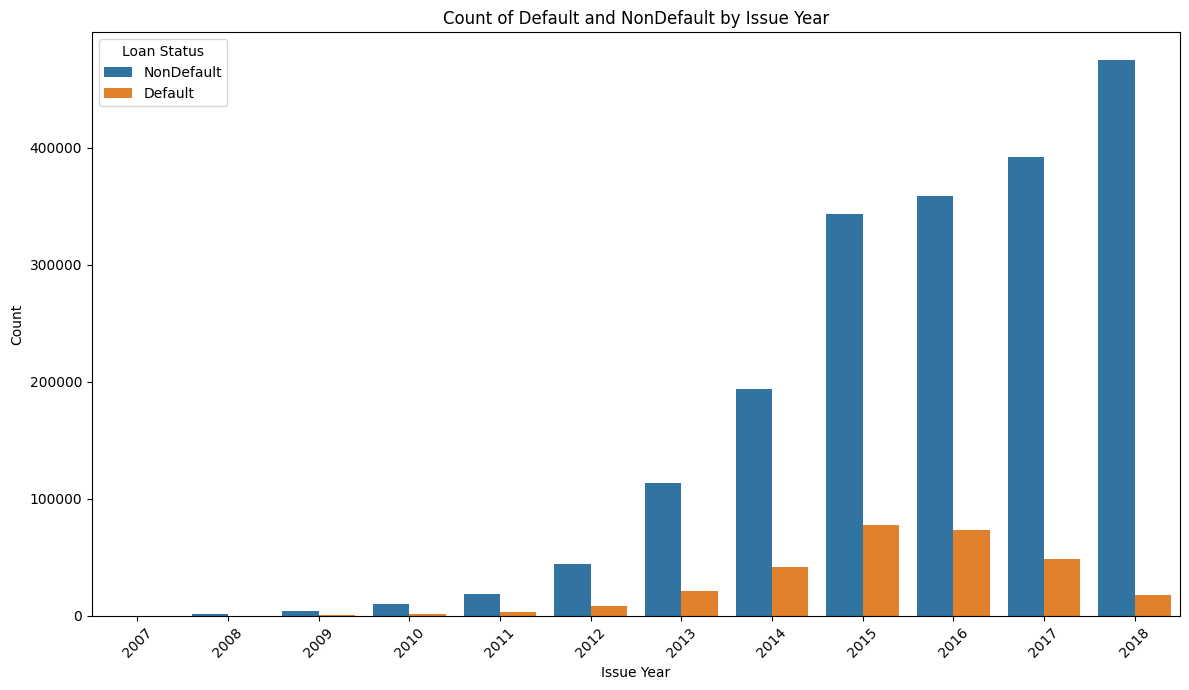

In [7]:
plt.figure(figsize=(12, 7))
sns.countplot(x='issue_year', hue='is_default', data=df1)
plt.title('Count of Default and NonDefault by Issue Year')
plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

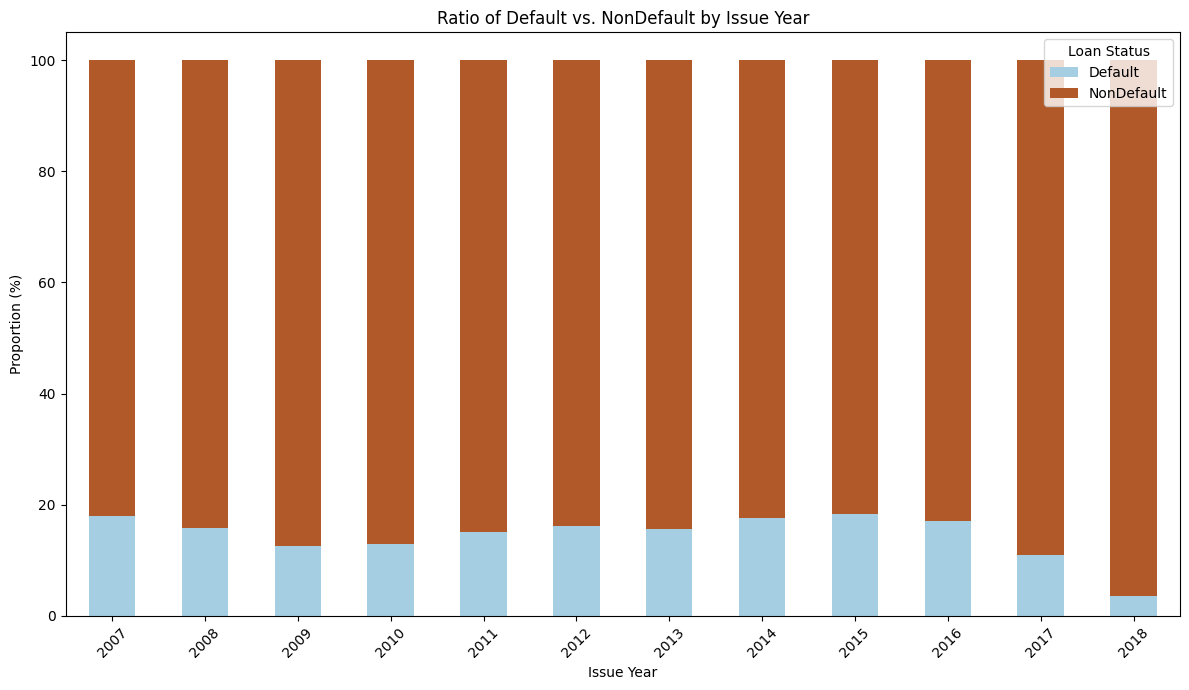

In [8]:
def plot_ratio_of_labels_by_year():
    df_grouped = df1.groupby(['issue_year', 'is_default']).size().unstack(fill_value=0)

    df_ratio = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
    
    # 3. 누적 막대 그래프 시각화
    df_ratio.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Paired')
    plt.title('Ratio of Default vs. NonDefault by Issue Year')
    plt.xlabel('Issue Year')
    plt.ylabel('Proportion (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Loan Status')
    plt.tight_layout()
    plt.show()
plot_ratio_of_labels_by_year()

데이터 필터링 기준 및 이유
___
~~분석데이터를 `2015`년 이후 데이터만 활용 후 추후 확장 고려~~

- 2015년 데이터만 필터링하여 분석해본 결과, 데이터 정합성 문제 발생
- 따라서 2016년도 이후 데이터를 활용하는 것으로 우선 진행


In [9]:
#df1 = df1[df1['issue_year'] == 2015]
df1 = df1[df1['issue_year'] >= 2016]
df1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_month,issue_year,issue_quarter,is_default
421097,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,NaN,NaN,NaN,NaN,Mar,2018,Q1,NonDefault
421098,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,Mar,2018,Q1,NonDefault
421099,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,NaN,NaN,NaN,NaN,Mar,2018,Q1,NonDefault
421100,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,NaN,NaN,NaN,NaN,Mar,2018,Q1,NonDefault
421101,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,Mar,2018,Q1,NonDefault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,NaN,24000.0,24000.0,24000.0,60 months,12.79,543.50,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,Oct,2016,Q4,NonDefault
2260695,88977788,NaN,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,Oct,2016,Q4,NonDefault
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,Oct,2016,Q4,NonDefault
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0,Oct,2016,Q4,Default


## 불필요한 특징 및 데이터 누출 의심 특징 처리

In [10]:
# 불필요한 특징 제거
df1 = df1.drop(['id', 'member_id', 'desc', 'url', 'purpose'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1365605 entries, 421097 to 2260698
Columns: 150 entries, loan_amnt to is_default
dtypes: float64(112), int64(1), object(37)
memory usage: 1.5+ GB


데이터 누출 의심 특징들 
- loan_status: 대출 상태 (삭제 처리- target variance 생성에 활용됨)
- last_pymnt_d: 마지막 상환일 (삭제 처리)
- pymnt_plan : 특별 상환 프로그램 진행 여부 (삭제 처리)
- debt_settlement_flag : 채무 조정절차 진행 여부 (삭제 처리)
- hardship_flag: (재정적 어려움으로 인해) 특별상환 계획을 진행 중인지 여부 (삭제 처리)



In [11]:
df1 = df1.drop(
    ['last_pymnt_d', 
     'loan_status', 
     'pymnt_plan', 
     'debt_settlement_flag',
     'hardship_flag',
     ], axis=1) 

## 결측치 처리
___

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_missing_counts_by_columns(df):
    '''
    컬럼별 결측치 숫자 및 비율 시각화 및 반환 함수
    '''

    # 컬럼별 결측치 숫자 및 비율 정보 추출
    tmp = df.isnull().sum() 
    tmp_ratio = (tmp / len(df)) * 100
    missing_info = pd.DataFrame({'Missing_Count': tmp, 'Missing_Ratio': tmp_ratio})
    missing_info = missing_info[missing_info['Missing_Count'] != 0].sort_values(by='Missing_Count')
    
    # 시각화 
    height = 5 + len(missing_info) // 10
    
    plt.figure(figsize=(20, height))
    ax = missing_info['Missing_Count'].plot(kind='barh')
    
    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                    ha='left', va='center')
                    
    plt.title('Column Missing Values')
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

    return missing_info

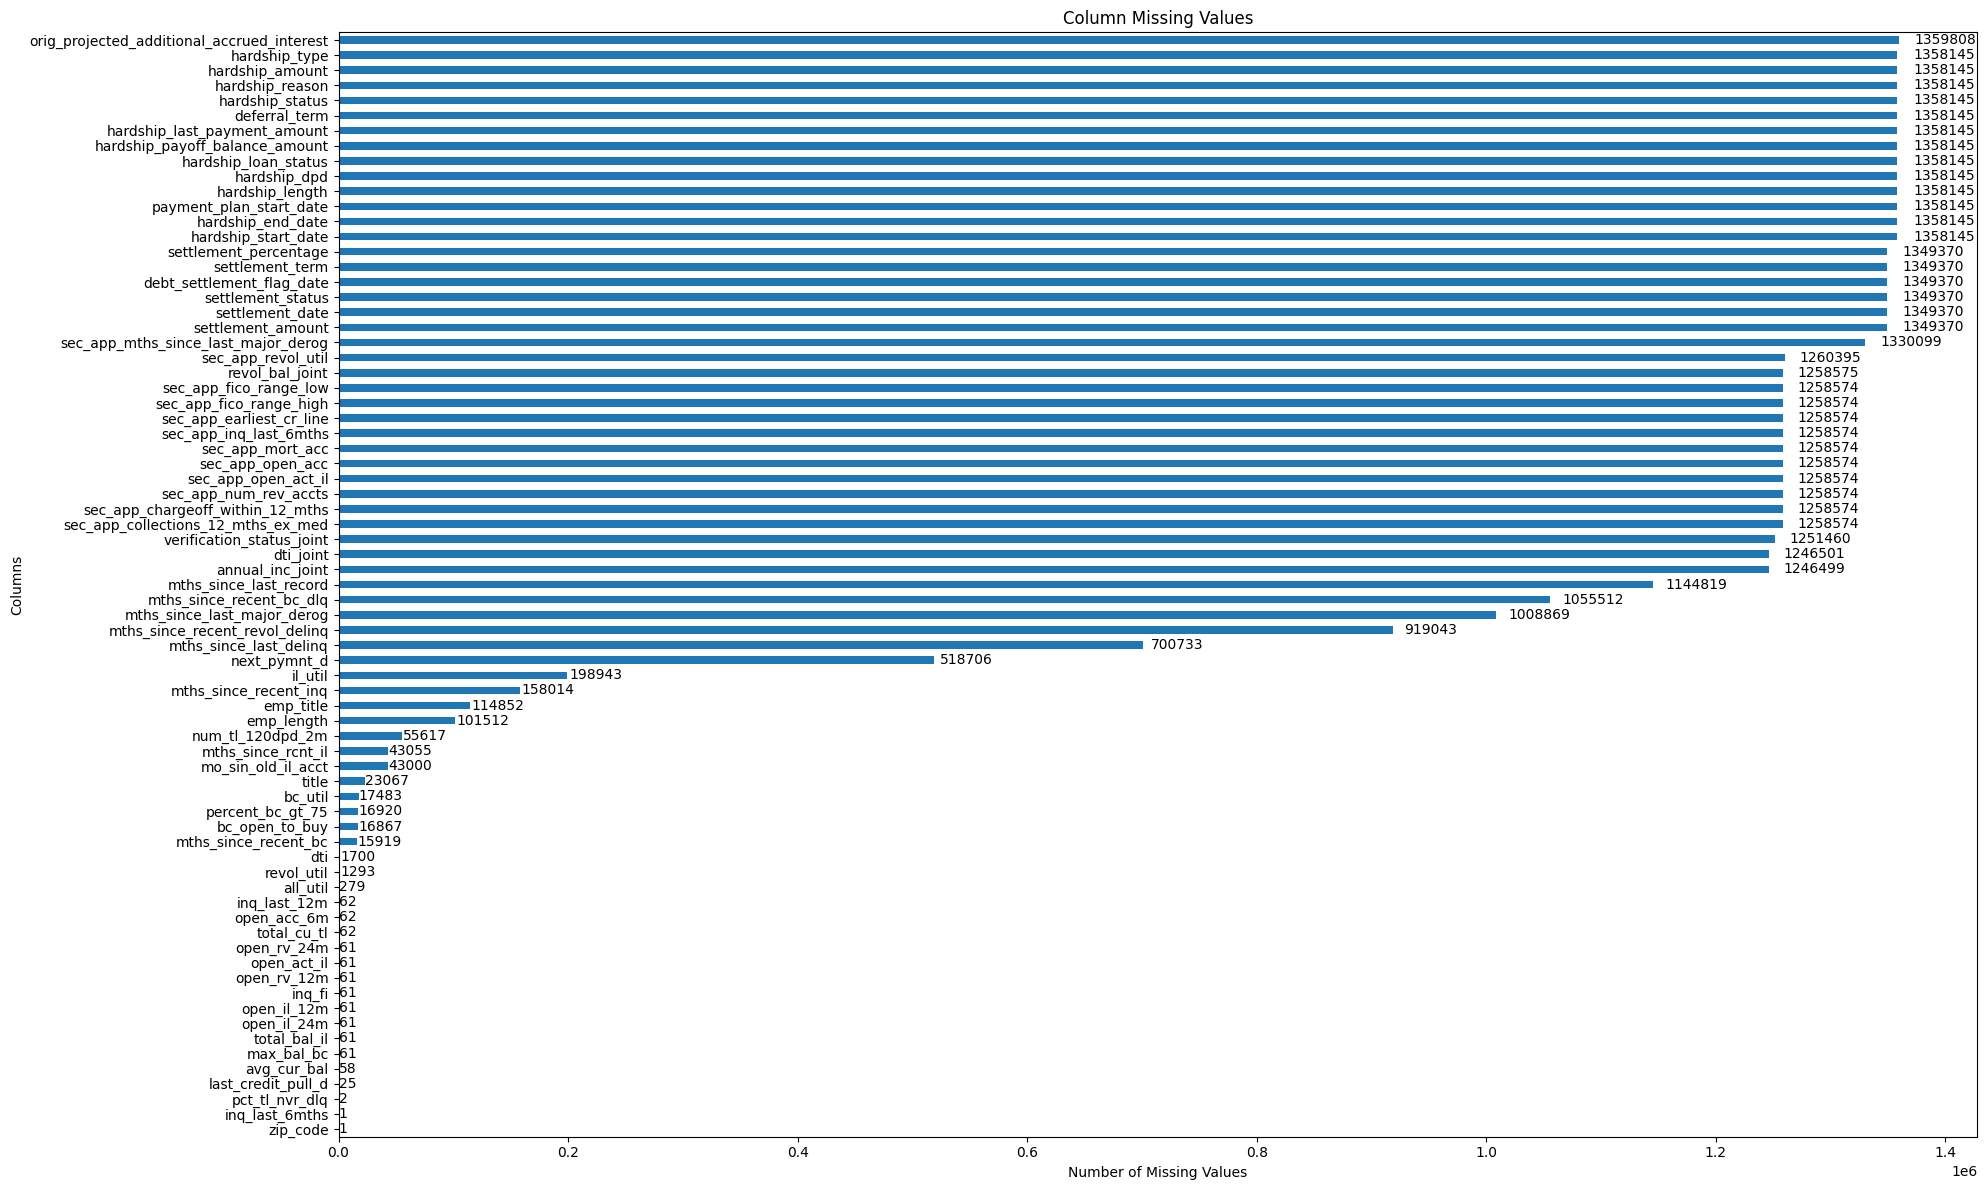

In [13]:
missing_counts_df1 = plot_missing_counts_by_columns(df1)

결측 비율 40% 초과 컬럼 정보 요약 
___
1. 공동 대출 신청자 관련 컬럼 (4개)
    - 이 컬럼들은 대출 신청자가 한 명이 아닌 두 명 이상일 경우에만 데이터가 기록됩니다. 대부분의 대출이 단독 신청이므로 결측치가 매우 높습니다.
</br></br>
2. 2차 신청자 관련 컬럼 (12개)
    - 이 컬럼들은 sec_app_ 접두사가 붙으며, 공동 대출 신청의 2차 신청자에 대한 금융 정보를 담고 있습니다.
</br></br>
3. 채무 조정 및 부도 관련 컬럼 (19개)
    - 이 컬럼들은 대출자가 재정적 어려움에 처했거나 채무 조정 프로그램을 이용했을 때만 데이터가 기록됩니다.
</br></br>
4. 그외 대출자 정보 (6개)
    - 이 컬럼들은 마지막 연체/채무 불이행 후 경과 개월 수 정보를 담고 있습니다.

In [14]:
# 결측 비율 40% 초과 컬럼 정보
print(missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40])
missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40].shape

                                            Missing_Count  Missing_Ratio
mths_since_last_delinq                             700733      51.313008
mths_since_recent_revol_delinq                     919043      67.299329
mths_since_last_major_derog                       1008869      73.877073
mths_since_recent_bc_dlq                          1055512      77.292629
mths_since_last_record                            1144819      83.832367
annual_inc_joint                                  1246499      91.278151
dti_joint                                         1246501      91.278298
verification_status_joint                         1251460      91.641434
sec_app_collections_12_mths_ex_med                1258574      92.162375
sec_app_chargeoff_within_12_mths                  1258574      92.162375
sec_app_num_rev_accts                             1258574      92.162375
sec_app_open_act_il                               1258574      92.162375
sec_app_open_acc                                  1

(41, 2)

1. 공동 대출 신청자 관련 컬럼  
- annual_inc_joint: 공동 신청 시 연간 소득
- dti_joint: 공동 신청 시 부채-소득 비율
- verification_status_joint: 공동 신청 시 소득 확인 상태
- revol_bal_joint: 공동 신청 시 회전식 신용 잔고

In [15]:
joint_related_columns = [col for col in missing_counts_df1.index if 'joint' in col]
display(missing_counts_df1.loc[joint_related_columns])

df1 = df1.drop(joint_related_columns, axis=1)

,Missing_Count,Missing_Ratio
annual_inc_joint,1246499,91.278151
dti_joint,1246501,91.278298
verification_status_joint,1251460,91.641434
revol_bal_joint,1258575,92.162448


2. 2차 신청자 관련 컬럼

- sec_app_collections_12_mths_ex_med: 2차 신청자의 12개월 내 의료 제외 채권 추심 기록
- sec_app_chargeoff_within_12_mths: 2차 신청자의 12개월 내 부도 처리 기록
- sec_app_num_rev_accts: 2차 신청자의 신용 계좌 수
- sec_app_open_act_il: 2차 신청자의 할부 계좌 수
- sec_app_open_acc: 2차 신청자의 개설된 총 계좌 수
- sec_app_inq_last_6mths: 2차 신청자의 최근 6개월 내 신용 조회 수
- sec_app_mort_acc: 2차 신청자의 모기지 계좌 수
- sec_app_fico_range_high / low: 2차 신청자의 FICO 신용 점수
- sec_app_earliest_cr_line: 2차 신청자의 가장 오래된 신용 거래 기록
- sec_app_revol_util: 2차 신청자의 신용 한도 사용률
- sec_app_mths_since_last_major_derog: 2차 신청자의 마지막 주요 채무 불이행 후 경과 개월 수

In [16]:
sec_app_related_columns = [col for col in missing_counts_df1.index if 'sec_app' in col]
display(missing_counts_df1.loc[sec_app_related_columns])

df1 = df1.drop(sec_app_related_columns, axis=1)

,Missing_Count,Missing_Ratio
sec_app_collections_12_mths_ex_med,1258574,92.162375
sec_app_chargeoff_within_12_mths,1258574,92.162375
sec_app_num_rev_accts,1258574,92.162375
sec_app_open_act_il,1258574,92.162375
sec_app_open_acc,1258574,92.162375
sec_app_mort_acc,1258574,92.162375
sec_app_inq_last_6mths,1258574,92.162375
sec_app_earliest_cr_line,1258574,92.162375
sec_app_fico_range_high,1258574,92.162375
sec_app_fico_range_low,1258574,92.162375


3. 채무 조정 및 부도 관련 컬럼 (19개)

- settlement_amount: 채무 조정 금액
- settlement_status: 채무 조정 상태
- settlement_date: 채무 조정일
- debt_settlement_flag_date: 채무 조정 플래그 설정일
- settlement_term: 채무 조정 기간
- settlement_percentage: 채무 조정된 금액의 비율
- hardship_status: 재정적 어려움 상태
- hardship_reason: 재정적 어려움 사유
- deferral_term: 상환 유예 기간
- hardship_amount: 재정적 어려움 지원 금액
- hardship_start_date / end_date: 재정적 어려움 시작/종료일
- hardship_type: 재정적 어려움 유형
- hardship_length: 재정적 어려움 기간
- hardship_last_payment_amount: 재정적 어려움 프로그램 내 마지막 상환액
- hardship_payoff_balance_amount: 재정적 어려움 프로그램 내 완납 잔액
- hardship_loan_status: 재정적 어려움 프로그램 내 대출 상태
- hardship_dpd: 재정적 어려움 프로그램 내 연체일 수
- payment_plan_start_date: 상환 계획 시작일입니다.
- deferral_term: 상환 유예 기간입니다.
- orig_projected_additional_accrued_interest: 재정적 어려움 프로그램으로 인해 발생한 추가 이자

In [17]:
settlement_related_columns = [col for col in missing_counts_df1.index if 'settlement' in col]
hardship_related_columns = [col for col in missing_counts_df1.index if 'hardship' in col] \
                         + ['orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'deferral_term']

display(missing_counts_df1.loc[settlement_related_columns + hardship_related_columns])

df1 = df1.drop(settlement_related_columns + hardship_related_columns, axis=1)

,Missing_Count,Missing_Ratio
settlement_amount,1349370,98.811150
settlement_date,1349370,98.811150
settlement_status,1349370,98.811150
debt_settlement_flag_date,1349370,98.811150
settlement_term,1349370,98.811150
settlement_percentage,1349370,98.811150
hardship_start_date,1358145,99.453722
hardship_end_date,1358145,99.453722
hardship_length,1358145,99.453722
hardship_dpd,1358145,99.453722


4. 그외 대출자 정보 (6개)
- next_pymnt_d: 다음 상환일.
- mths_since_last_delinq: 마지막 연체 후 경과 개월 수.
- mths_since_recent_revol_delinq: 최근 리볼빙 계좌 연체 후 경과 개월 수.
- mths_since_last_major_derog: 마지막 주요 채무 불이행 후 경과 개월 수.
- mths_since_recent_bc_dlq: 최근 신용카드 연체 후 경과 개월 수.
- mths_since_last_record: 마지막 공개 기록(파산 등) 후 경과 개월 수.


In [18]:
keywords_to_filter = ['next_pymnt_d', 'mths_since_la', 
                      'mths_since_recent_revol_delinq', 'mths_since_recent_bc_dlq', 'mths_since_last_record']
                      
etc_features = [col for col in missing_counts_df1.index if any(keyword in col for keyword in keywords_to_filter)]
etc_features.remove('sec_app_mths_since_last_major_derog')
display(missing_counts_df1.loc[etc_features])

df1 = df1.drop(etc_features, axis=1)

,Missing_Count,Missing_Ratio
next_pymnt_d,518706,37.983604
mths_since_last_delinq,700733,51.313008
mths_since_recent_revol_delinq,919043,67.299329
mths_since_last_major_derog,1008869,73.877073
mths_since_recent_bc_dlq,1055512,77.292629
mths_since_last_record,1144819,83.832367


5.  결측 비율 5% 초과 컬럼
    - il_util: 할부 계좌의 총 신용한도 사용률.
    - mths_since_recent_inq: 최근 신용 조회(새로운 신용 신청 이력(예, 대출 신청, 카드 신청 등)이 있을 때 발생) 후 경과 개월 수.
    - emp_title: 직업명.
    - emp_length: 현 직장 근무 기간.
    



In [19]:
keywords_to_filter = ['il_util', 'mths_since_recent_inq', 'emp_title', 'emp_length']

missing_above_5p = [col for col in missing_counts_df1.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1.loc[missing_above_5p])

df1['il_util'] = df1['il_util'] = df1['il_util'].fillna(0) # 할부 계좌가 없는 경우로 판단
df1['mths_since_recent_inq'] = df1['mths_since_recent_inq'].fillna(999) # 새로운 신용 신청 이력이 없는 경우로 판단
df1['emp_title'] = df1['emp_title'].fillna('unemployed') # 직업이 없는 케이스로 판단
df1['emp_length'] = df1['emp_length'].fillna(0) # 직업이 없는 케이스로 판단

,Missing_Count,Missing_Ratio
emp_length,101512,7.433482
emp_title,114852,8.410338
mths_since_recent_inq,158014,11.570989
il_util,198943,14.568122


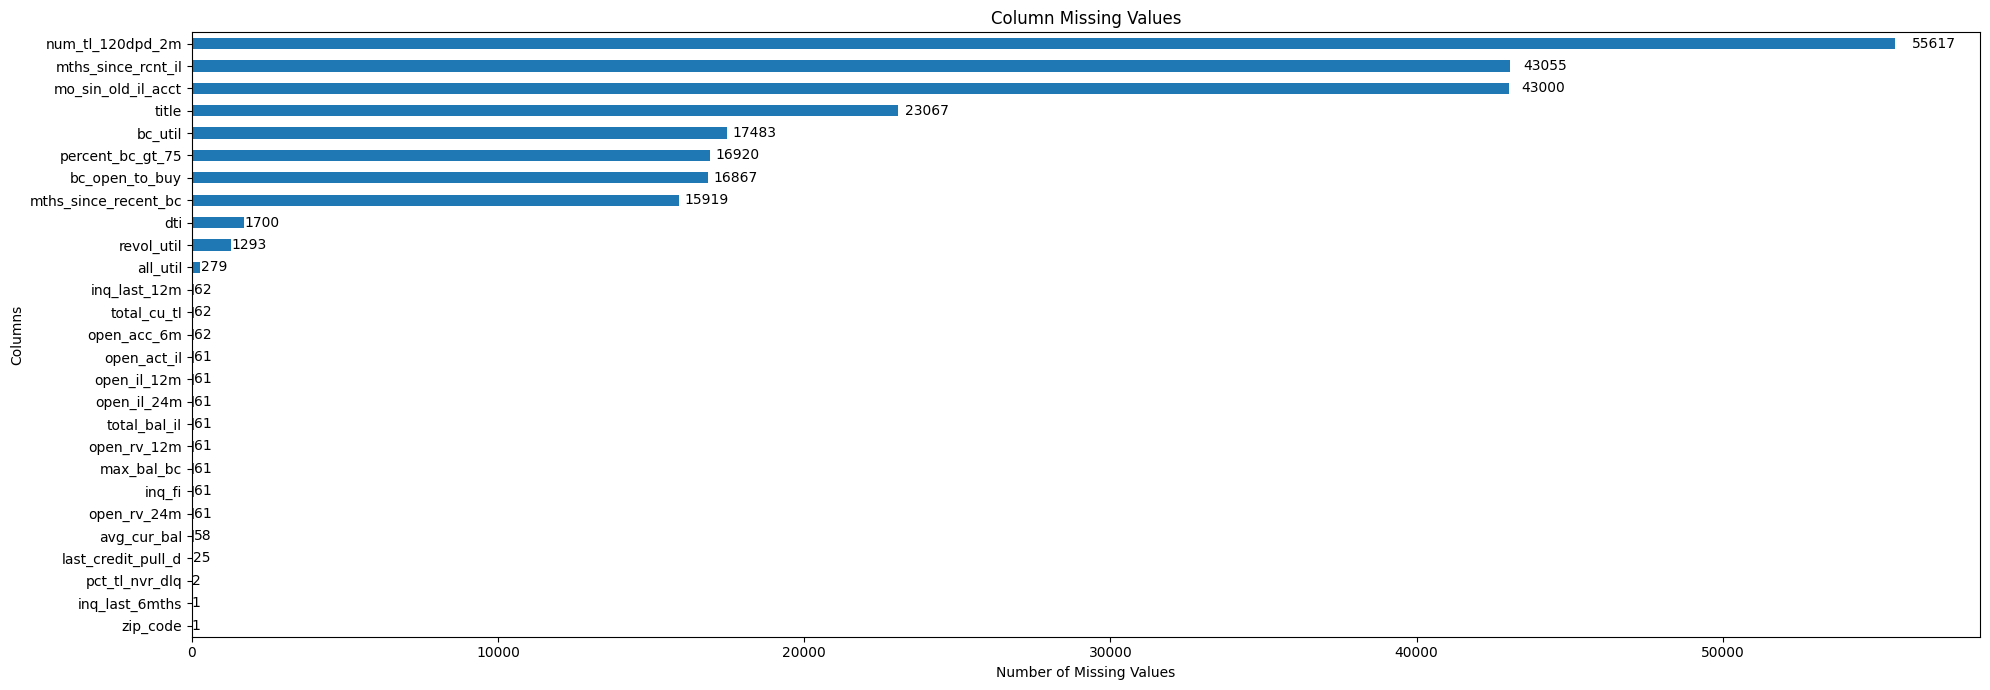

                      Missing_Count  Missing_Ratio
zip_code                          1       0.000073
inq_last_6mths                    1       0.000073
pct_tl_nvr_dlq                    2       0.000146
last_credit_pull_d               25       0.001831
avg_cur_bal                      58       0.004247
open_rv_24m                      61       0.004467
inq_fi                           61       0.004467
max_bal_bc                       61       0.004467
open_rv_12m                      61       0.004467
total_bal_il                     61       0.004467
open_il_24m                      61       0.004467
open_il_12m                      61       0.004467
open_act_il                      61       0.004467
open_acc_6m                      62       0.004540
total_cu_tl                      62       0.004540
inq_last_12m                     62       0.004540
all_util                        279       0.020431
revol_util                     1293       0.094683
dti                            

In [20]:
missing_counts_df1_rev = plot_missing_counts_by_columns(df1)
print(missing_counts_df1_rev)

6. 결측 비율이 1% 초과 컬럼
    - num_tl_120dpd_2m: 최근 2년간 120일 이상 연체된 계좌 수.
    - mths_since_rcnt_il: 최근 할부 계좌 개설 후 경과 개월 수.
    - mo_sin_old_il_acct: 가장 오래된 할부 계좌 개설 후 경과 개월 수.
    - title: 대출자가 기입한 대출 목적 제목.
    - bc_util: 신용카드 한도 사용률.
    - percent_bc_gt_75: 한도 75% 이상 사용 중인 신용카드 비율.
    - bc_open_to_buy: 신용카드 한도 대비 여유 금액.
    - mths_since_recent_bc: 최근 신용카드 개설 후 경과 개월 수.



In [21]:
keywords_to_filter = ['num_tl_120dpd_2m', 'mths_since_rcnt_il', 'mo_sin_old_il_acct', 'title', 'bc_util',
                      'percent_bc_gt_75', 'bc_open_to_buy', 'mths_since_recent_bc']

missing_above_1p = [col for col in missing_counts_df1_rev.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1_rev.loc[missing_above_1p])

df1['num_tl_120dpd_2m'] = df1['num_tl_120dpd_2m'].fillna(0) # 연체 이력이 없는 케이스로 판단
df1['title'] = df1['title'].fillna('None') # 대출 시 title 작성 안한 경우로 판단

# 할부 계좌가 없는 경우로 판단
df1['mths_since_rcnt_il'] = df1['mths_since_rcnt_il'] = df1['mths_since_rcnt_il'].fillna(0) 
df1['mo_sin_old_il_acct'] = df1['mo_sin_old_il_acct'].fillna(0)

# 신용카드가 없는 경우로 판단
df1['bc_util'] = df1['bc_util'].fillna(0) 
df1['percent_bc_gt_75'] = df1['percent_bc_gt_75'].fillna(0)
df1['bc_open_to_buy'] = df1['bc_open_to_buy'].fillna(0)
df1['mths_since_recent_bc'] = df1['mths_since_recent_bc'].fillna(0)

,Missing_Count,Missing_Ratio
mths_since_recent_bc,15919,1.165710
bc_open_to_buy,16867,1.235130
percent_bc_gt_75,16920,1.239011
bc_util,17483,1.280238
title,23067,1.689141
mo_sin_old_il_acct,43000,3.148788
mths_since_rcnt_il,43055,3.152815
num_tl_120dpd_2m,55617,4.072700


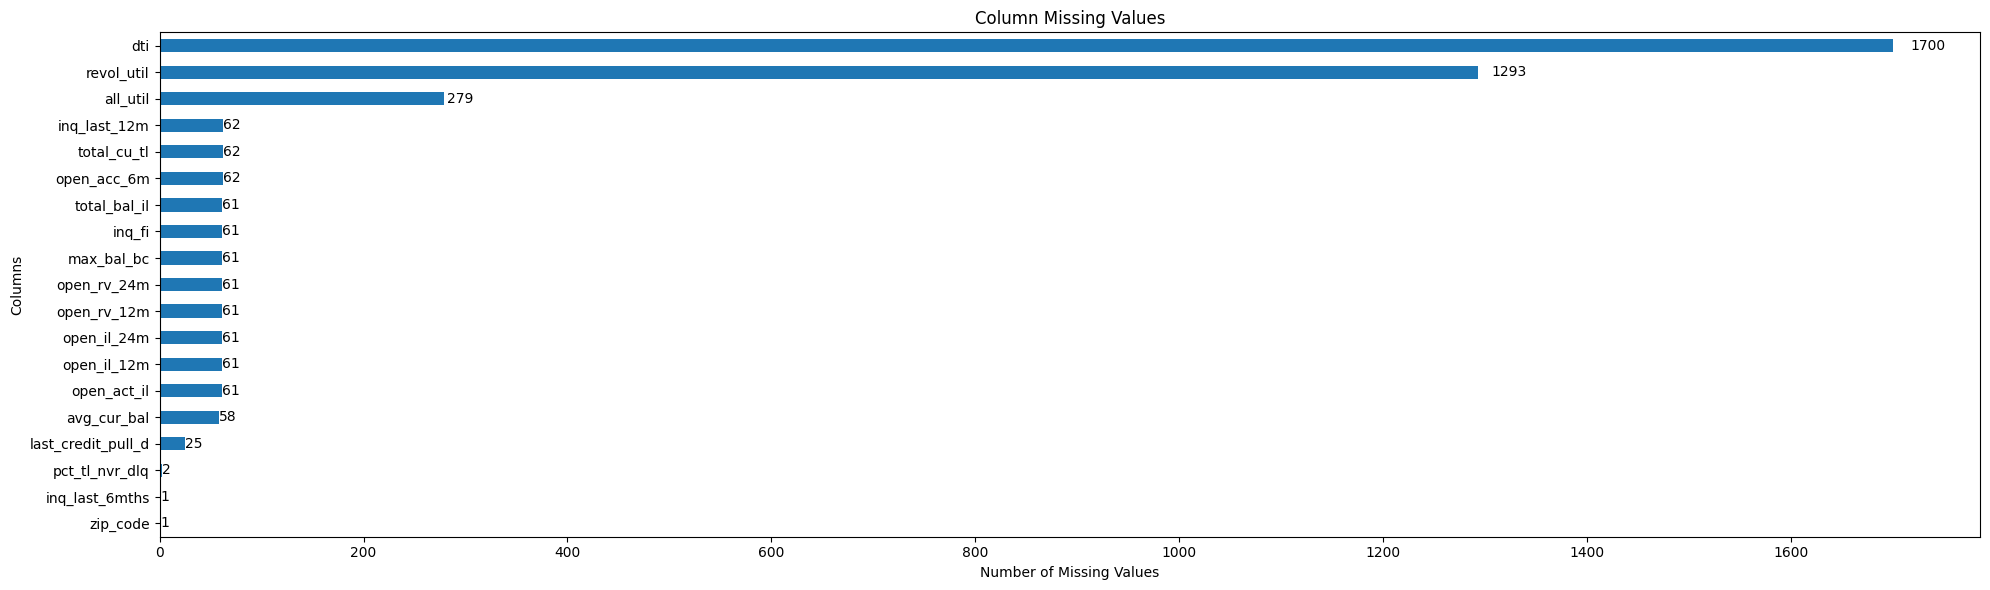

                    Missing_Count  Missing_Ratio
zip_code                        1       0.000073
inq_last_6mths                  1       0.000073
pct_tl_nvr_dlq                  2       0.000146
last_credit_pull_d             25       0.001831
avg_cur_bal                    58       0.004247
open_act_il                    61       0.004467
open_il_12m                    61       0.004467
open_il_24m                    61       0.004467
open_rv_12m                    61       0.004467
open_rv_24m                    61       0.004467
max_bal_bc                     61       0.004467
inq_fi                         61       0.004467
total_bal_il                   61       0.004467
open_acc_6m                    62       0.004540
total_cu_tl                    62       0.004540
inq_last_12m                   62       0.004540
all_util                      279       0.020431
revol_util                   1293       0.094683
dti                          1700       0.124487


In [22]:
missing_counts_df1_rev2 = plot_missing_counts_by_columns(df1)
print(missing_counts_df1_rev2)

7. 결측 비율 1% 미만 컬럼

    - dti: 부채-소득 비율.
    - revol_util: 리볼빙 계좌 신용 한도 사용률.
    - all_util: 모든 신용 계좌의 총 신용한도 사용률.
    - inq_last_12m: 최근 12개월간 신용 조회 건수.
    - total_cu_tl: 신용 조합(credit union) 계좌 총 개수.
    - open_acc_6m: 최근 6개월간 신규 신용 계좌 개설 수.
    - total_bal_il: 할부 계좌(차량, 학자금 대출 등)의 총 잔액.
    - inq_fi: 최근 융자(mortgage/revolving 제외) 관련 조회 건수.
    - max_bal_bc: 신용카드 계좌의 최대 잔액.
    - open_rv_12m: 최근 12개월간 신규 회전식 계좌(신용카드 등) 개설 수.
    - open_rv_24m: 최근 24개월간 신규 회전식 계좌 개설 수.
    - open_il_12m: 최근 12개월간 신규 할부 계좌 개설 수.
    - open_il_24m: 최근 24개월간 신규 할부 계좌 개설 수.
    - open_act_il: 현재 개설된 할부 계좌 수.
    - avg_cur_bal: 모든 계좌의 평균 현재 잔액입니다.
    - last_credit_pull_d: 마지막 신용 조회일.
    - pct_tl_nvr_dlq: 한 번도 연체되지 않은 계좌의 비율입니다.
    - inq_last_6mths: 지난 6개월간의 신용 조회 건수입니다.
    - zip_code : 대출자의 거주지 우편번호



    

In [23]:
# 신용카드가 없는 경우로 판단
df1['revol_util'] = df1['revol_util'].fillna(df1['revol_util'].median()) 

# 결측 비율이 낮기 때문에 drop 처리
df1 = df1.dropna(subset=['dti', 'all_util', 'last_credit_pull_d', 'pct_tl_nvr_dlq', 'inq_last_12m', 'zip_code']) 

# 나머지 컬럼에 있던 결측들은 함께 처리되었음

In [24]:
df1.isna().sum().sum()

0

In [25]:
df1.shape

(1363597, 103)

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1363597 entries, 421097 to 2260698
Columns: 103 entries, loan_amnt to is_default
dtypes: float64(83), int64(1), object(19)
memory usage: 1.1+ GB


## 범주형 특징 전처리

In [27]:
categorical_columns = df1.select_dtypes('object').columns 

summary_cat_features = {}
for col in categorical_columns:
  nuniq = df1[col].nunique()
  vals = df1[col].unique()
  summary_cat_features[col] = {'n_unique': nuniq, 'values': vals}

summary_cat_features = pd.DataFrame(summary_cat_features).T.sort_values('n_unique')
display(summary_cat_features)

,n_unique,values
term,2,"[ 36 months, 60 months]"
disbursement_method,2,"[Cash, DirectPay]"
application_type,2,"[Individual, Joint App]"
initial_list_status,2,"[w, f]"
is_default,2,"[NonDefault, Default]"
verification_status,3,"[Verified, Source Verified, Not Verified]"
issue_quarter,4,"[Q1, Q3, Q2, Q4]"
home_ownership,5,"[RENT, OWN, MORTGAGE, ANY, NONE]"
grade,7,"[D, B, G, A, C, E, F]"
issue_month,12,"[Mar, Feb, Jan, Sep, Aug, Jul, Jun, May, Apr, ..."


In [28]:
# n_unique = 2 인 특징
summary_cat_features[summary_cat_features.n_unique ==2]

,n_unique,values
term,2,"[ 36 months, 60 months]"
disbursement_method,2,"[Cash, DirectPay]"
application_type,2,"[Individual, Joint App]"
initial_list_status,2,"[w, f]"
is_default,2,"[NonDefault, Default]"


term

In [29]:
df1['term'] = df1['term'].map({summary_cat_features.loc['term']['values'][0]:36,
                              summary_cat_features.loc['term']['values'][1]:60}).astype(int)

emp_title --> 직업별 평균 연소득(emp_title_avg_inc)
- 대출자의 emp_title 정보는 emp_title별 평균 연소득 정보를 활용해 대출자의 상환 능력을 가늠할 수 있는 정보로 활용하고 있다고 판단하였음
- 하지만 고유값의 수가 너무 많고, emp_title 값에는 대소문자 및 특수문자가 혼재되어 있어 자연어 전처리 또한 필요
- 이에, emp_title에 대한 자연어 전처리 후 annual_inc 정보를 활용하여 emp_title별 평균 연소득 특징을 생성하였음


In [30]:
import re

def func_emp_title(x):
  cleaned_text = re.sub(r'\t', '', str(x).lower()) # 탭(\t) 제거

  cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text) # [^\w\s]는 알파벳, 숫자, 밑줄, 공백을 제외한 문자를 공백(' ')으로 변환

  cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 여러 개의 공백을 공백 하나로 통합
  return cleaned_text

df1['emp_title'] = df1['emp_title'].apply(func_emp_title)

# 직업별 평균 년소득 특징 생성 (emp_title_avg_annual_inc 활용)
emp_title_avg_annual_inc = df1.groupby('emp_title')['annual_inc'].mean()

df1['emp_title_avg_inc'] = df1['emp_title'].map(emp_title_avg_annual_inc)
df1 = df1.drop('emp_title', axis=1)

zip_code --> 우편번호별 평균 연소득(zip_code_avg_annual_inc)
- 대출자의 거주지 정보를 가진 특징은 2가지로 zip_code와 addr_state가 있음
- zip_code의 n_unique가 914개로 addr_state보다 더 많은 정보를 가지고 있다고 판단하지만 zip_code의 n_unique가 너무 크기 때문에 인코딩을 하기엔 학습에 비효율적이라고 판단하였음
- 이에, annual_inc 정보를 활용하여 우편번호별 평균 연소득 특징을 생성 후 zip_code와 addr_state 특징은 삭제하였음 

In [31]:
zip_code_avg_annual_inc = df1.groupby('zip_code')['annual_inc'].mean()

df1['zip_code_avg_inc'] = df1['zip_code'].map(zip_code_avg_annual_inc)
df1 = df1.drop(['zip_code', 'addr_state'], axis=1)

earliest_cr_line --> 신용거래기간 (credit_history_length)  
- earliest_cr_line 특징 도한 고유값의 수가 적지 않아 인코딩 시 모델의 복잡도를 높여 학습이 비효율적이라고 판단하였음 
- 이에, issue_d와 earliest_cr_line 정보를 활용하여 신용거래기간 특징을 생성하였음
- 신용거래기간은 얼마나 오랫동안 신용을 관리해왔는지 알려주는 지표로 신용평가에 중요한 정보로 활용되고 있음


In [32]:
def create_credit_history(df):
    df_copy = df.copy()
    df_copy['earliest_cr_line_dt'] = pd.to_datetime(df_copy['earliest_cr_line'], format='%b-%Y')
    df_copy['issue_d_dt'] = pd.to_datetime(df_copy['issue_d'], format='%b-%Y')
    
    # 신용거래기간
    df_copy['credit_history_length'] = (
        (df_copy['issue_d_dt'].dt.year - df_copy['earliest_cr_line_dt'].dt.year) * 12 +
        (df_copy['issue_d_dt'].dt.month - df_copy['earliest_cr_line_dt'].dt.month))
    
    return df_copy['credit_history_length']

df1['credit_history_length'] = create_credit_history(df1)
df1 = df1.drop(['earliest_cr_line'], axis=1)

last_credit_pull_d --> 마지막 신용 조회 후 경과기간(time_since_last_credit_check)
___
- issue_d와 last_credit_pull_d 정보를 활용하여 마지막 신용조회 후 경과기간 특징을 생성하였음


In [33]:
def create_time_since_last_credit_check(df):
    df_copy = df.copy()
    df_copy['issue_d_dt'] = pd.to_datetime(df_copy['issue_d'], format='%b-%Y')
    df_copy['last_credit_pull_d_dt'] = pd.to_datetime(df_copy['last_credit_pull_d'], format='%b-%Y')

    # 마지막 신용 조회 기간 계산
    df_copy['time_since_last_credit_check'] = (
        (df_copy['issue_d_dt'].dt.year - df_copy['last_credit_pull_d_dt'].dt.year) * 12 +
        (df_copy['issue_d_dt'].dt.month - df_copy['last_credit_pull_d_dt'].dt.month))
    
    df_copy['time_since_last_credit_check'] = np.where(
        df_copy['time_since_last_credit_check'] < 0, 0, df_copy['time_since_last_credit_check'])
    
    return df_copy['time_since_last_credit_check']

df1['time_since_last_credit_check'] = create_time_since_last_credit_check(df1)
df1 = df1.drop(['last_credit_pull_d'], axis=1)

※ 여기서 mths_since_recent_inq vs. time_since_last_credit_check의 차이
- mths_since_recent_inq (최근 신용 조회 후 경과 개월 수):
이 변수는 하드 인콰이어리(Hard Inquiry), 즉 대출이나 신용카드와 같이 새로운 신용을 신청한 시점을 기준으로 합니다. 하드 인콰이어리는 신용 점수에 영향을 미칠 수 있습니다. 짧은 기간에 여러 번 발생하면 재정적 어려움의 신호로 해석될 수 있습니다.

- time_since_last_credit_check (마지막 신용 조회 후 경과 기간):
이 변수는 신용 풀(Credit Pull), 즉 하드 인콰이어리와 소프트 인콰이어리(Soft Inquiry)를 모두 포함합니다. 소프트 인콰이어리는 본인이 자신의 신용을 조회하거나, 광고성 목적의 신용 조회를 할 때 발생하며 신용 점수에 영향을 주지 않습니다.

grade, sub_grade

In [34]:
display(df1[['grade', 'sub_grade']].value_counts().sort_index())
df1 = df1.drop('grade', axis=1)

grade  sub_grade
A      A1           63721
       A2           46943
       A3           49552
       A4           61103
       A5           62557
B      B1           79975
       B2           77472
       B3           74787
       B4           83657
       B5           90921
C      C1           91850
       C2           78259
       C3           78372
       C4           77552
       C5           74783
D      D1           45097
       D2           42600
       D3           37808
       D4           31000
       D5           26309
E      E1           15171
       E2           12768
       E3           12415
       E4           10890
       E5           12927
F      F1            6122
       F2            3869
       F3            3316
       F4            2685
       F5            2541
G      G1            2203
       G2            1263
       G3            1094
       G4            1036
       G5             979
Name: count, dtype: int64

- sub_grade의 앞철자는 'A'부터 'G'까지, 뒤에 있는 숫자는 '1'부터 '5'의 값을 가짐
- 이를 순서대로 수치형으로 변환
    - 예, 'A1'--> 35, 'A2'--> 34, ... , 'G5'--> 1

In [35]:
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sub_grades_ordered = [f'{g}{i}' for g in grades for i in range(1, 6)]

sub_grade_map = {sub: len(sub_grades_ordered) - i for i, sub in enumerate(sub_grades_ordered)}

df1['sub_grade_score'] = df1['sub_grade'].map(sub_grade_map)
df1 = df1.drop('sub_grade', axis=1)

In [36]:
def func_emp_length_to_numeric(emp_length_series):
    emp_length_series = emp_length_series.fillna(0)
    emp_length_mapping = {
        0 : 0,
        '< 1 year': 0.5,
        '10+ years': 12}
    
    for i in range(1, 10):
        emp_length_mapping[f'{i} year'] = i
        emp_length_mapping[f'{i} years'] = i
    
    numeric_emp_length = emp_length_series.map(emp_length_mapping)
    return numeric_emp_length

df1['emp_length'] = func_emp_length_to_numeric(df1['emp_length'])

title
- 빈도수가 1인 값들은 Other로 변환

In [37]:
df1['title'].value_counts()

title
Debt consolidation           733790
Credit card refinancing      303503
Home improvement              96643
Other                         95123
Major purchase                32571
None                          23059
Medical expenses              18584
Car financing                 14875
Business                      13946
Vacation                      10593
Home buying                   10271
Moving and relocation          9782
Green loan                      855
Credit Card Consolidation         1
Learning and training             1
Name: count, dtype: int64

In [38]:
def func_title(df):
  tmp = df['title'].value_counts()
  others = tmp[tmp<=1].index

  df['title'] = df['title'].replace(others, 'Other')
  return df

df1 = func_title(df1)

issue_d
- issue_d로부터 연, 월, 분기 정보를 이미 추출한 상태이며, 신용거래기간 및 마지막 신용조회 후 경과기간 특징 또한 생성한 상태
- - 충분히 정보를 추출했다고 판단하여 삭제

In [39]:
df1 = df1.drop('issue_d', axis=1)

범주형 특징 전처리 결과 확인

In [40]:
categorical_columns = df1.select_dtypes('object').columns 

summary_cat_features = {}
for col in categorical_columns:
  nuniq = df1[col].nunique()
  vals = df1[col].unique()
  summary_cat_features[col] = {'n_unique': nuniq, 'values': vals}

summary_cat_features = pd.DataFrame(summary_cat_features).T.sort_values('n_unique')
display(summary_cat_features)

,n_unique,values
initial_list_status,2,"[w, f]"
application_type,2,"[Individual, Joint App]"
disbursement_method,2,"[Cash, DirectPay]"
is_default,2,"[NonDefault, Default]"
verification_status,3,"[Verified, Source Verified, Not Verified]"
issue_quarter,4,"[Q1, Q3, Q2, Q4]"
home_ownership,5,"[RENT, OWN, MORTGAGE, ANY, NONE]"
issue_month,12,"[Mar, Feb, Jan, Sep, Aug, Jul, Jun, May, Apr, ..."
title,13,"[Other, Debt consolidation, Medical expenses, ..."


In [41]:
df1[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1363597 entries, 421097 to 2260698
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   home_ownership       1363597 non-null  object
 1   verification_status  1363597 non-null  object
 2   title                1363597 non-null  object
 3   initial_list_status  1363597 non-null  object
 4   application_type     1363597 non-null  object
 5   disbursement_method  1363597 non-null  object
 6   issue_month          1363597 non-null  object
 7   issue_quarter        1363597 non-null  object
 8   is_default           1363597 non-null  object
dtypes: object(9)
memory usage: 104.0+ MB


In [42]:
df1.to_csv('accepted_from_2016.csv', index = False)